# 07 Sparse Multi Input example using the Abalone dataset

_[Estimated time of execution: 5 min]_

This notebook shows how to train a multi-input dataset using MOGPTK.

Abalone is a dataset containing the measurements of 4177 abalones (a type of marine snail) for their lengths, weights, sex and age. Specifically, the following features are given:

- Sex: M, F, and I (infant)
- Length in mm: longest shell measurement
- Diameter in mm: perpendicular to length
- Height in mm: with meat in shell
- Whole weight in grams: whole abalone
- Shucked weight in grams: weight of meat
- Viscera weight in grams: gut weight (after bleeding)
- Shell weight in grams: after being dried
- Rings: +1.5 gives the age in years

Here we will use the length and weight features as independent variables, and the number of rings (i.e. their age) as the dependent variable.

In [1]:
import numpy as np
import torch
import mogptk

torch.manual_seed(1);

Load in the dataset and select the relevant columns. Then standardize the number of rings so that it has zero mean and unit variance.

In [2]:
columns = ["Sex","Length","Diameter","Height","Whole weight","Shucked weight","Viscera weight","Shell weight","Rings"]

data = mogptk.LoadCSV("data/abalone/abalone.data",
                      x_col=["Length","Diameter","Height","Whole weight","Shucked weight","Viscera weight","Shell weight"],
                      y_col=["Rings"], names=columns)
data.transform(mogptk.TransformNormalize())

Set up the model by using Titsias' sparse Gaussian process inference with a `100` inducing (sparse) points. The initial points will be spread randomly over the input space.

We will use the squared exponential kernel with our 7 input dimensions. We initialize the parameters to values that are close to the minimum to help training.

In [3]:
# Choose kernel
kernel = mogptk.gpr.SquaredExponentialKernel(input_dims=7)

# Choose inference
inference = mogptk.Titsias(inducing_points=100, init_inducing_points='random')

# Set up model
model = mogptk.Model(data, kernel, inference=inference)

# Initialize parameters
model.gpr.kernel.lengthscale.assign(np.random.rand(7))

Training will be performed using the default Adam optimizer with a learning rate of `1.0` for a `100` iterations. We will additionally be measuring the error between the prediction and the target values using the mean absolute percentage error (MAPE), which is a relative error with respect to the target values. In our case, we are able to reach a 16% error relative to the target values.

In [4]:
model.train(iters=500, verbose=True, error='mape', lr=0.05)

Starting optimization using Adam
‣ Model: Titsias
  ‣ Kernel: SquaredExponentialKernel
  ‣ Likelihood: GaussianLikelihood
‣ Channels: 1
‣ Parameters: 709
‣ Training points: 4177
‣ Iterations: 500
    0/500   0:00:00  loss=     5870.46  error=     27.2526
  213/500   0:00:10  loss=    -53.6161  error=     14.8084
  439/500   0:00:20  loss=    -1915.79  error=     14.7676
  500/500   0:00:22  loss=    -1958.52  error=      14.762
Optimization finished in 22.742 seconds


(array([ 5870.45677623,  5481.58576962,  5133.58913029,  4762.94418021,
         4585.46688361,  4431.35541711,  4291.95130865,  4175.29207344,
         4101.1911563 ,  4040.83617815,  3968.75460797,  3898.88590551,
         3841.5497686 ,  3798.24803056,  3765.9957062 ,  3740.32455877,
         3717.13445603,  3688.74432933,  3663.87981591,  3636.10282688,
         3608.21689957,  3584.84449317,  3560.09163061,  3537.81367569,
         3513.79256739,  3490.82310852,  3467.74266651,  3445.63228748,
         3423.9119254 ,  3401.6785199 ,  3379.24777172,  3357.15364093,
         3335.32292898,  3313.60949793,  3291.98382599,  3270.49408898,
         3249.08191022,  3228.001461  ,  3206.6848245 ,  3185.63357672,
         3164.8736072 ,  3143.846362  ,  3122.8379892 ,  3101.97853335,
         3081.2081713 ,  3060.62838472,  3039.84642321,  3019.1609154 ,
         2998.55595514,  2977.89651281,  2957.29383372,  2936.77270161,
         2916.25429365,  2895.76883677,  2875.31825599,  2854.91

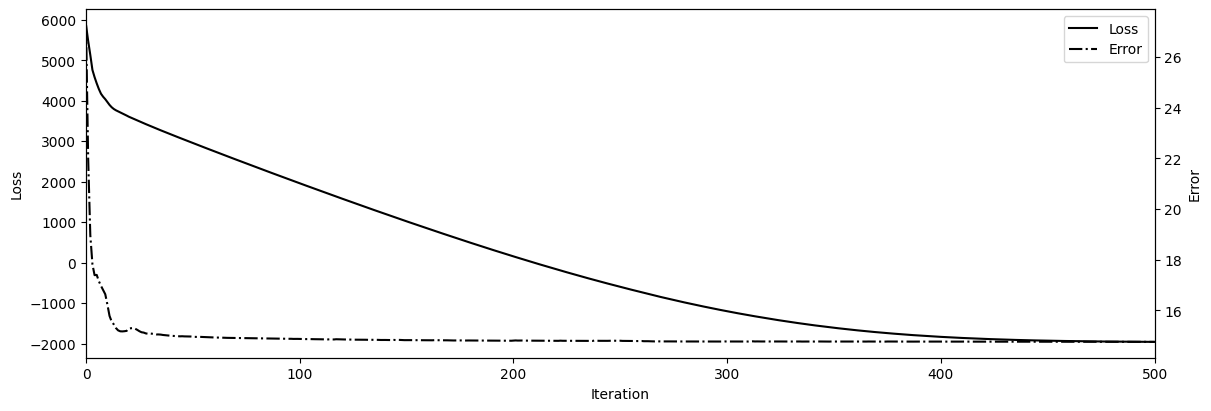

In [5]:
model.plot_losses();

The loss and error decline rapidly and consistently, confirming that training was succesfull. The following kernel and model parameters have been obtained.

In [6]:
model.print_parameters()